# Log Normal Out of the Money Price Simulation



In [246]:

import math

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

vol_2min = btcusd_1min['ret_2min'].std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


## Monte Carlo Simulation

The following will be used in the simulation below:  

```
S(T) = S(0) * exp[(r - 0.5 * σ^2)*T + σ√Tz]

where
S(0) = 30,000.00 USD
T = 2 minutes, i.e. 3.80e-06 year
r = 0
σ = 150.53% annual volatility

```

In [247]:

# underlying price at t=0
S0 = 30_000.00

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# fixes the seed for reproducibility
rng = default_rng(99)
# rng = default_rng()

# underlying price vector at maturity
ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * rng.standard_normal(I))

# mean of terminal prices
ST_mean = ST.mean()

# standard deviation of terminal prices
ST_std = ST.std()

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|S(T)|{ST[:5].round(1)}...|\n"

table3 = ""
table3 += f"|S(T) mean|{float('%.7g' % ST_mean)}|\n"
table3 += f"|S(T) std|{float('%.4g' % ST_std)}|\n"

md(f"""### Simulation calculated variables
{header}
{table}
### Terminal prices samples
{header}
{table2}
### Terminal prices stats
{header}
{table3}""")


### Simulation calculated variables
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|I|1000000|

### Terminal prices samples
|variable|value|
|:-:|-:|
|S(T)|[30007.1 29959.  30004.3 30060.4 29845.6]...|

### Terminal prices stats
|variable|value|
|:-:|-:|
|S(T) mean|30000.06|
|S(T) std|88.05|


In [248]:

# at-the-money strike price => fair value @ 50%-50% exercise probability
K_at_money = S0

# call option payoff at maturity
CT_at_money = np.maximum(ST - K_at_money, 0)

# out-of-the-money strike price => 
# add once the premium of the at-the-money option to the strike price as an experiment
K = S0 + CT_at_money.mean()

# call option payoff at maturity
CT = np.maximum(ST - K, 0)

CT_mean = CT.mean()
CT_std = CT.std()

# call option fair value
C0 = math.exp(-r * T) * CT_mean

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|K|{float('%.8g' % K)} USD|\n"

table2 = ""
table2 += f"|C(T)|{CT[:5].round(1)}...|\n"

table3 = ""
table3 += f"|C(T) mean|{float('%.4g' % CT_mean)}|\n"
table3 += f"|C(T) std|{float('%.4g' % CT_std)}|\n"
table3 += f"|C0|{float('%.4g' % C0)}|\n"

md(f"""### Option payoff variables
{header}
{table}
### Terminal option payoff samples
{header}
{table2}
### Terminal option payoff stats
{header}
{table3}""")


### Option payoff variables
|variable|value|
|:-:|-:|
|K|30035.16 USD|

### Terminal option payoff samples
|variable|value|
|:-:|-:|
|C(T)|[ 0.   0.   0.  25.2  0. ]...|

### Terminal option payoff stats
|variable|value|
|:-:|-:|
|C(T) mean|20.35|
|C(T) std|39.45|
|C0|20.35|


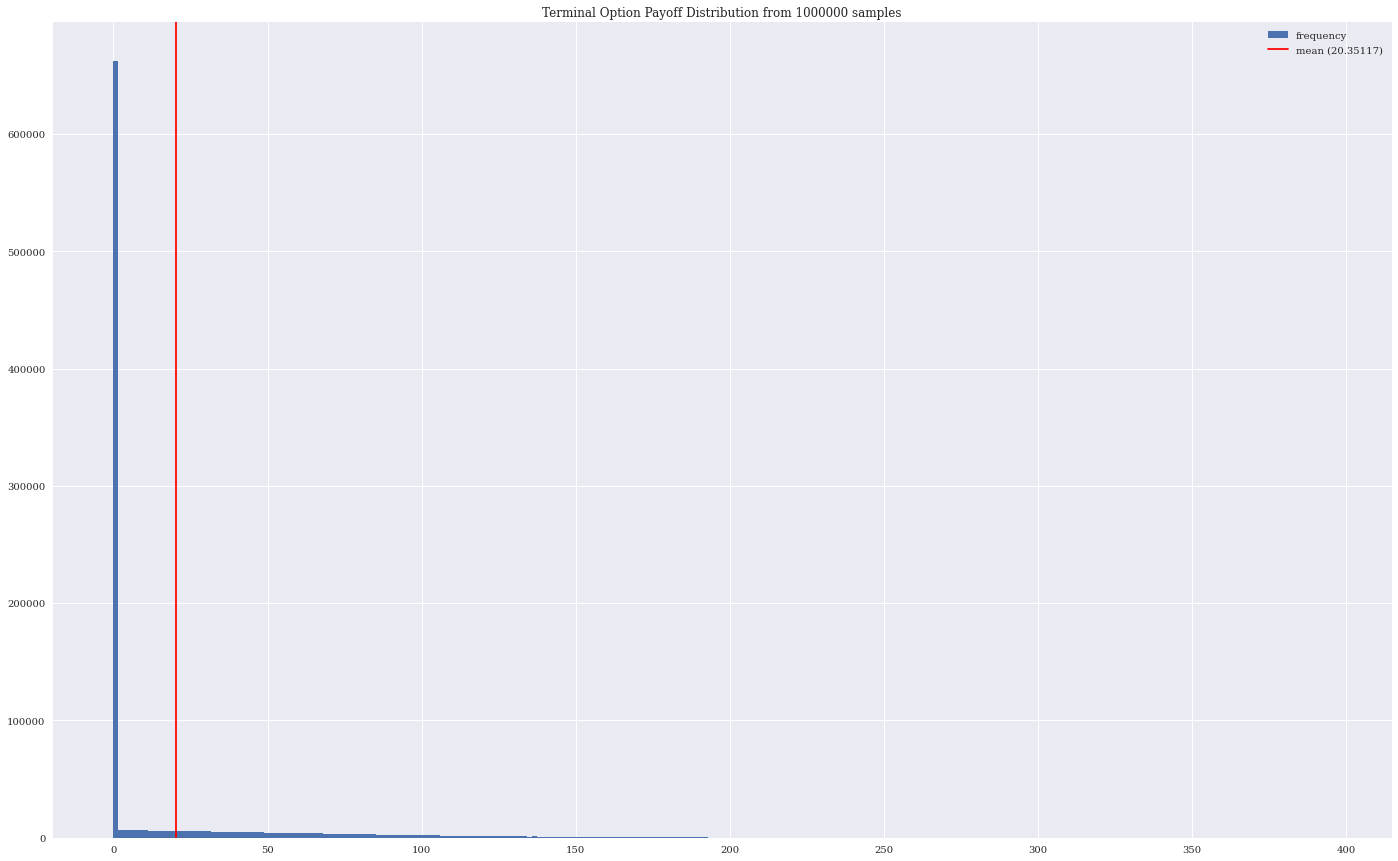

In [249]:

plt.figure(figsize=(24, 15))
plt.hist(CT, bins=250, label='frequency');

plt.axvline(CT_mean, color='r', label=f"mean ({float('%.7g' % (CT_mean))})")

plt.title(f'Terminal Option Payoff Distribution from {I} samples')
plt.legend(loc='best');
plt.show()

## Present Value of the expected payoff

Given that, in this case, the time interval (maturity) is 2 minutes, there's no interest to be gained by investing a certain amount temporarily in a risk-free asset (bank account, short-rate bond, etc.) so the risk-free rate is zero and the discounted / present value is the same as the terminal / future value.

```
C0 = Expected Value / Average / Mean of [C(T)]

```



## Black–Scholes–Merton option price

The BSM call option price formula is:
```
C(0) = S(0) * N(d1) - K * exp[-r * T] * N(d2)

with
d1 = (ln[S(0) / K] + (r + 0.5 * σ^2)*T) / σ√T
d2 = d1 - σ√T

and where
N() is the standard normal cummulative probability distribution function
N(d2) can be interpreted as the probability that a call option will be exercised
N(d1) is not easy to interpret by itself
S(0)*N(d1)*exp[rT] can be interpreted as the expected terminal underlying price when underlying prices less than the strike are counted as zero (to present value is then: S(0)*N(d1))
```

So the call option price is the discounted expected value of the terminal underlying price (with below strike prices accounted as zero) less the the strike price given exercise (weighted by the probability of exercise).




In [250]:

# theoretical non-simulated call price
d1 = (log(S0/K) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
d2 = d1 - sigma * sqrt(T)
N_d1 = norm.cdf(d1)
N_d2 = norm.cdf(d2)
BSM_C0 = S0 * N_d1 - K * exp(-r*T) * N_d2

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|K|{float('%.8g' % K)} USD|\n"
table += f"|BSM C0|{float('%.4g' % BSM_C0)} USD|\n"
table += f"|MC C0|{float('%.4g' % C0)} USD|\n"

table2 = ""
table2 += f"|d1|{float('%.6g' % (d1))}|\n"
table2 += f"|d2|{float('%.6g' % (d2))}|\n"
table2 += f"|N(d1)|{float('%.4g' % (N_d1))}|\n"
table2 += f"|N(d2)|{float('%.4g' % (N_d2))}|\n"
table2 += f"|S(0)*N(d1)|{float('%.7g' % (S0*N_d1))} USD|\n"
table2 += f"|-K*N(d2)|{float('%.7g' % (-K*N_d2))} USD|\n"
table2 += f"|S(0)*N(d1)-K*N(d2)|{float('%.4g' % (S0*N_d1-K*N_d2))} USD|\n"

md(f"""### Option price comparison
{header}
{table}
### BSM Terms
{header}
{table2}""")


### Option price comparison
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|K|30035.16 USD|
|BSM C0|20.33 USD|
|MC C0|20.35 USD|

### BSM Terms
|variable|value|
|:-:|-:|
|d1|-0.397566|
|d2|-0.400502|
|N(d1)|0.3455|
|N(d2)|0.3444|
|S(0)*N(d1)|10364.25 USD|
|-K*N(d2)|-10343.91 USD|
|S(0)*N(d1)-K*N(d2)|20.33 USD|


## Identifying BSM terms in terminal price distribution



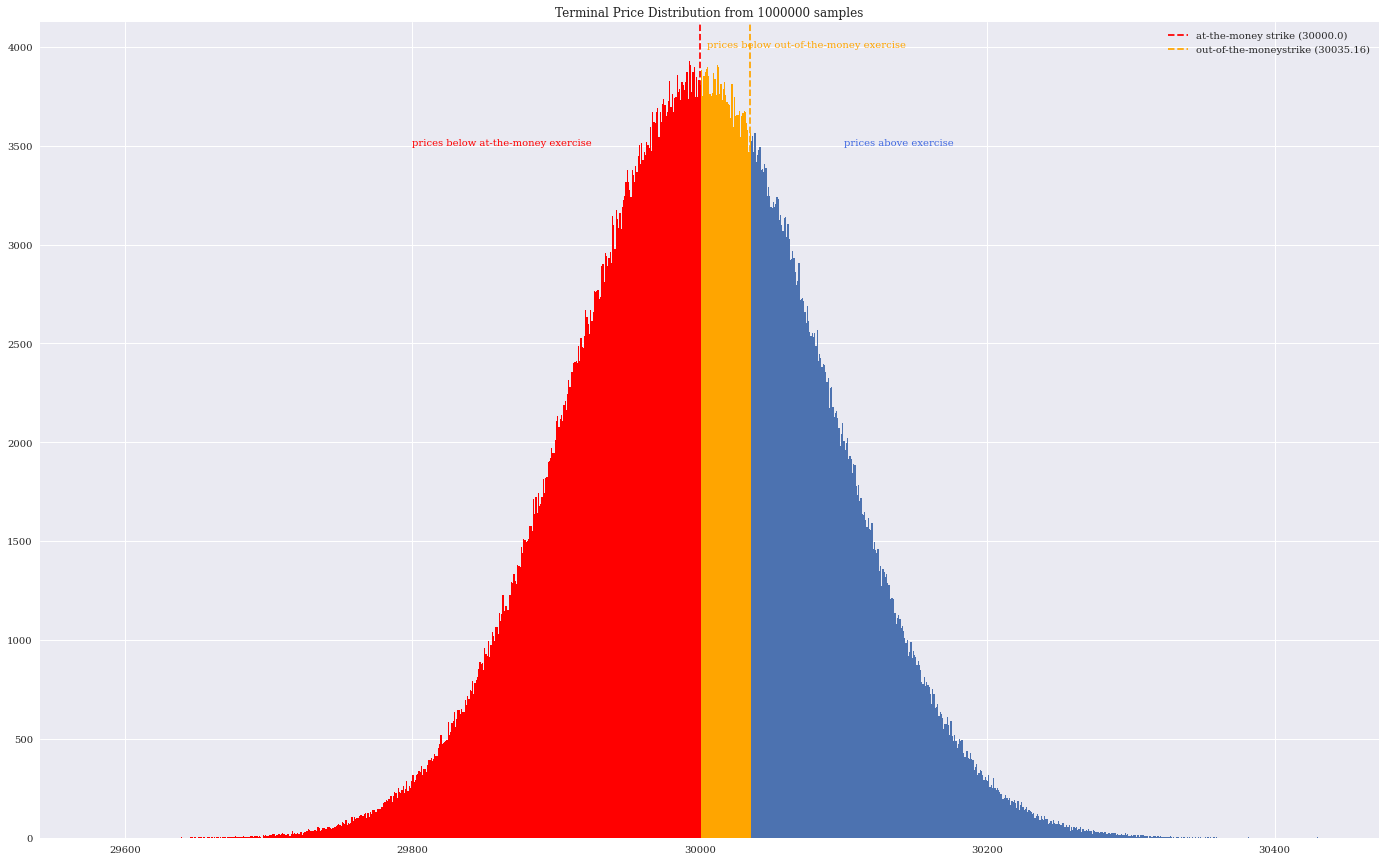

In [251]:

plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(ST, bins=1000);
for c, p in zip(bins, patches):
    if c <= K_at_money:
        plt.setp(p, 'facecolor', 'red')
    elif c > K_at_money and c <= K:
        plt.setp(p, 'facecolor', 'orange')
    # else:
    #     plt.setp(p, 'facecolor', 'royalblue')

plt.axvline(K_at_money, color='r', label=f"at-the-money strike ({float('%.7g' % (K_at_money))})", linestyle='--')
plt.axvline(K, color='orange', label=f"out-of-the-moneystrike ({float('%.7g' % (K))})", linestyle='--')

plt.text(29800, 3500, "prices below at-the-money exercise", color='r')
plt.text(30005, 4000, "prices below out-of-the-money exercise", color='orange')
plt.text(30100, 3500, "prices above exercise", color='royalblue')

plt.title(f'Terminal Price Distribution from {I} samples')
plt.legend(loc='best');
plt.show()


In [252]:

ST_below_K = ST[ST <= K]
ST_above_K = ST[ST > K]

ST_N_d1 = np.concatenate((ST_below_K*0, ST_above_K))


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Count(ST <= K)|{ST_below_K.size}|\n"
table += f"|Count(ST  > K)|{ST_above_K.size}|\n"
table += f"|Total Count|{ST_below_K.size + ST_above_K.size}|\n"
table += f"|Nbr of sims (I)|{I}|\n"
table += f"|Percent(ST <= K)|{float('%.4g' % (ST_below_K.size/I))}|\n"
table += f"|Percent(ST  > K)|{float('%.4g' % (ST_above_K.size/I))}|\n"

table2 = ""
table2 += f"|S(T)*N(d1)|{float('%.7g' % (ST_N_d1.mean()))} USD|\n"
table2 += f"|-K*N(d2)|{float('%.7g' % (-K*(ST_above_K.size/I)))} USD|\n"
table2 += f"|S(T)\*N(d1) - K\*N(d2)|{float('%.4g' % (ST_N_d1.mean()-K*(ST_above_K.size/I)))} USD|\n"

md(f"""### Frequency stats
{header}
{table}
### BSM Terms from terminal prices
{header}
{table2}
""")


### Frequency stats
|variable|value|
|:-:|-:|
|Count(ST <= K)|655404|
|Count(ST  > K)|344596|
|Total Count|1000000|
|Nbr of sims (I)|1000000|
|Percent(ST <= K)|0.6554|
|Percent(ST  > K)|0.3446|

### BSM Terms from terminal prices
|variable|value|
|:-:|-:|
|S(T)*N(d1)|10370.35 USD|
|-K*N(d2)|-10350.0 USD|
|S(T)\*N(d1) - K\*N(d2)|20.35 USD|



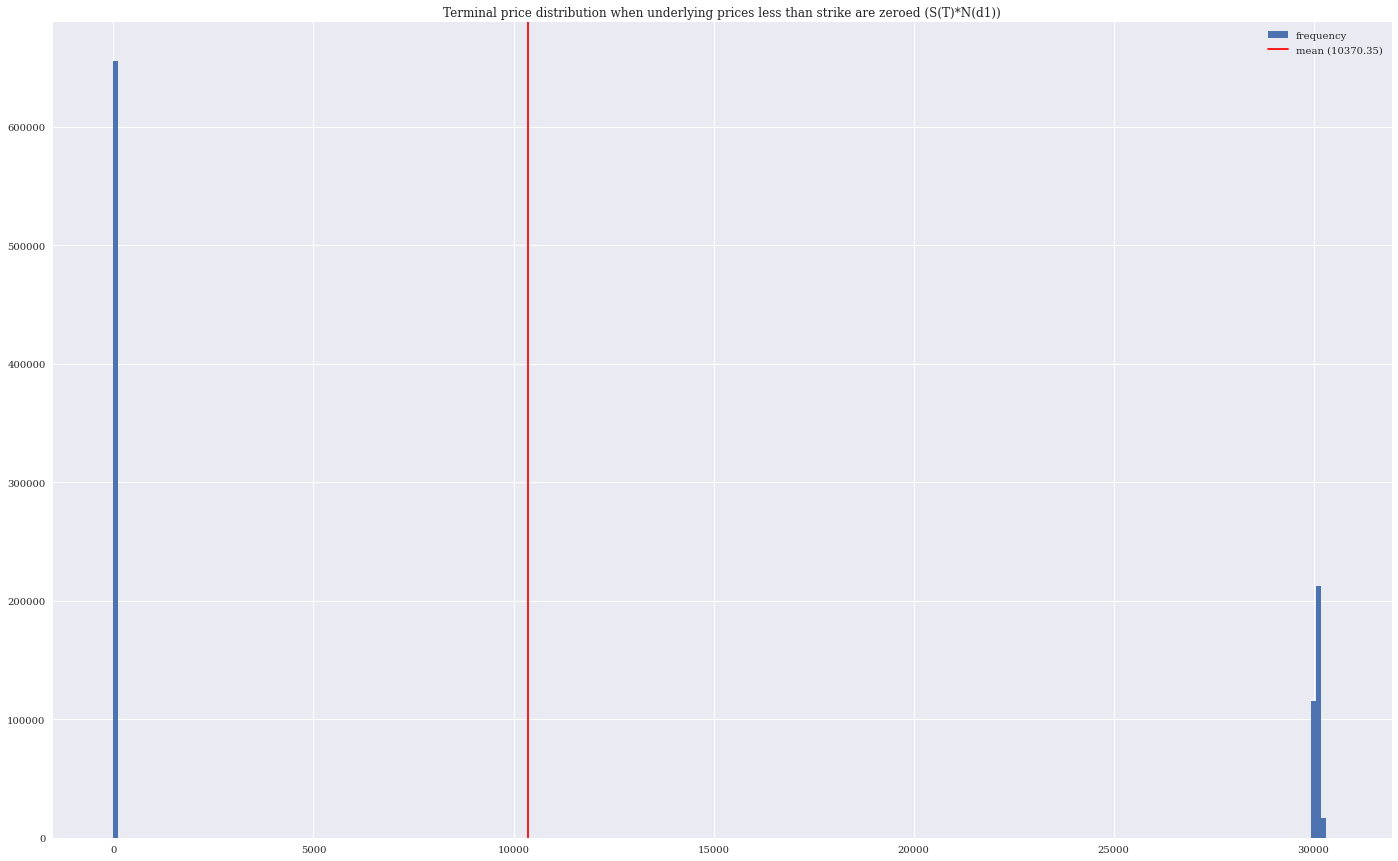

In [253]:

plt.figure(figsize=(24, 15))
plt.hist(ST_N_d1, bins=250, label='frequency');

plt.axvline(ST_N_d1.mean(), color='r', label=f"mean ({float('%.7g' % (ST_N_d1.mean()))})")

plt.title(f'Terminal price distribution when underlying prices less than strike are zeroed (S(T)*N(d1))')
plt.legend(loc='best');
plt.show()

## Out-of-the-money call option pricing summary

In this version of the simulation, a strike price equal to the initial (t=0) underlying price **plus a certain spread** was used to compare "out-of-the-money" pricing.

The difference in strike was highlighted in orange in the price distribution to show where the effect of a "fee" on the strike price is.

The first assumption in deriving the pricing of the no-premium option is that most users find utility in it by itself even at a marked up strike price. 

So are willing to incur the fee on the strike price and will exercise the option even if the underlying price is below the strike price but above the initial underlying price - orange section.

So the maturity payoff of the option is: 
- C_out_money_no_premium(T) = S(T) - K, if S(T) > K_at_money, else 0
    - note that if K > S(T) > K_at_money, S(T) - K is negative, yet exercised for utility purposes

versus: 
- C_out_money(T) = S(T) - K, if S(T) > K, else 0

The subtility being that the exercise is calculated based on the at-the-money strike level (instead of the out-of-the-money strike) while the payoff is calculated based on the actual strike as normal (the out-of-the-money strike). 

So part of the payoff at maturity is effectively negative opening the possibility for the expected value of the payoff to be zero at a certain strike price. 

So the question is, what is that strike price and is it a usable fee proxy or is it too large that it voids the assumption of excercise at a loss?








<!-- 
The Pnl is therefore: K_at_money - S(T) - C_out_money_prime(T)




This affects the probabil


The other assumption is that if arbitrageurs are present their expected gains will be counter balanced by the fee on the strike price, i.e. the out-of-the-money contract.

One must realize that the arbitrage opportunity on the no-premium option does not disapear but is merely funded by the other users.

So the question is what fee level balances the two sides.



The underwriter of the option in such a context receives the out-of-the-money strike

 as if the option had the probability of exercise of an at-the-money option,

```
Pnl = K_at_the_money - S(T) - C(T)
```

1. The arbitrageurs' expected gain is the premium of the out-of-the-money option: E[max(ST - K_at_money, 0)].
1. The other users' expected cost is the terminal underlying price less the out-of-the-money strike: 

The subtility being that the probability of exercise is calculated based on the at-the-money strike level while the pnl is based on the out-of-the-money strike.

```
ST
``` -->

## No-premium Option Payoff

In [254]:


# not exercised
CT_below_K_at_money = ST[ST <= K_at_money] * 0

# exercised at a loss
CT_below_K = ST[ST > K_at_money]
CT_below_K = CT_below_K[CT_below_K <= K] - K

# exercised at a gain
CT_above_K = ST[ST > K] - K

# call option payoff at maturity
CT_no_premium = ST_N_d1 = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

CT_no_premium_mean = CT_no_premium.mean()
CT_no_premium_std = CT_no_premium.std()

# call option fair value
C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|K|{float('%.8g' % K)} USD|\n"
table += f"|K_at_money|{float('%.8g' % K_at_money)} USD|\n"

table2 = ""
table2 += f"|C_no_premium(T)|{CT_no_premium[-5:].round(1)}...|\n"
table2 += f"|Count(C_no_premium(T))|{CT_no_premium.size}|\n"

table3 = ""
table3 += f"|C_no_premium(T) mean|{float('%.4g' % CT_no_premium_mean)}|\n"
table3 += f"|C_no_premium(T) std|{float('%.4g' % CT_no_premium_std)}|\n"
table3 += f"|C0_no_premium|{float('%.4g' % C0_no_premium)}|\n"

md(f"""### Option payoff variables
{header}
{table}
### Terminal option payoff samples
{header}
{table2}
### Terminal option payoff stats
{header}
{table3}""")


### Option payoff variables
|variable|value|
|:-:|-:|
|K|30035.16 USD|
|K_at_money|30000.0 USD|

### Terminal option payoff samples
|variable|value|
|:-:|-:|
|C_no_premium(T)|[102.   81.2   2.1  33.  101.2]...|
|Count(C_no_premium(T))|1000000|

### Terminal option payoff stats
|variable|value|
|:-:|-:|
|C_no_premium(T) mean|17.59|
|C_no_premium(T) std|41.55|
|C0_no_premium|17.59|


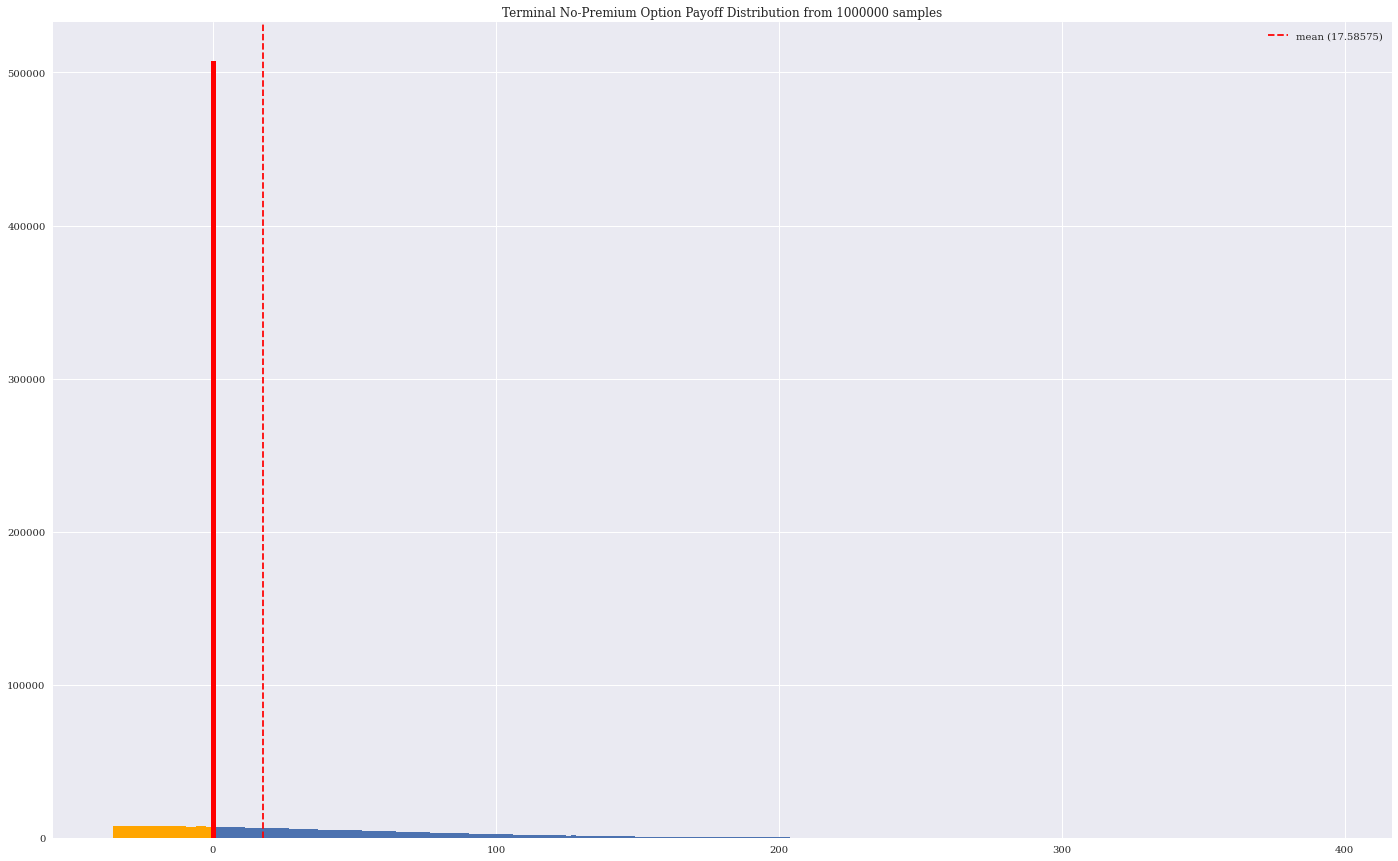

In [255]:

plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(CT_no_premium, bins=250);
mode_index = n.argmax()
for c, p in zip(bins, patches):
    if c >= bins[mode_index] and c < bins[mode_index+1]:
        plt.setp(p, 'facecolor', 'red')
    elif c < 0:
        plt.setp(p, 'facecolor', 'orange')
    # else:
    #     plt.setp(p, 'facecolor', 'royalblue')

plt.axvline(CT_no_premium_mean, color='r', label=f"mean ({float('%.7g' % (CT_no_premium_mean))})", linestyle='--')

plt.title(f'Terminal No-Premium Option Payoff Distribution from {I} samples')
plt.legend(loc='best');
plt.show()


In [256]:

# not exercised
ST_below_K_at_money = ST[ST <= K_at_money]

# exercised at a loss
ST_below_K = ST[ST > K_at_money]
ST_below_K = ST_below_K[ST_below_K <= K]
 
# exercised at a gain
ST_above_K = ST[ST > K]


ST_N_d1 = np.concatenate((ST_below_K_at_money*0, ST_below_K, ST_above_K))


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Count(ST <= K_at_money)|{ST_below_K_at_money.size}|\n"
table += f"|Count(ST <= K)|{ST_below_K.size}|\n"
table += f"|Count(ST  > K)|{ST_above_K.size}|\n"
table += f"|Total Count|{ST_below_K_at_money.size + ST_below_K.size + ST_above_K.size}|\n"
table += f"|Nbr of sims (I)|{I}|\n"
table += f"|Percent(ST <= K)|{float('%.4g' % (ST_below_K_at_money.size/I))}|\n"
table += f"|Percent(ST  > K)|{float('%.4g' % ((ST_below_K.size + ST_above_K.size)/I))}|\n"

table2 = ""
table2 += f"|S(T)*N(d1)|{float('%.7g' % (ST_N_d1.mean()))} USD|\n"
table2 += f"|-K*N(d2)|{float('%.7g' % (-K*((ST_below_K.size + ST_above_K.size)/I)))} USD|\n"
table2 += f"|S(T)\*N(d1) - K\*N(d2)|{float('%.4g' % (ST_N_d1.mean()-K*((ST_below_K.size + ST_above_K.size)/I)))} USD|\n"

md(f"""### Frequency stats
{header}
{table}
### BSM Terms from terminal prices
{header}
{table2}
""")


### Frequency stats
|variable|value|
|:-:|-:|
|Count(ST <= K_at_money)|500166|
|Count(ST <= K)|155238|
|Count(ST  > K)|344596|
|Total Count|1000000|
|Nbr of sims (I)|1000000|
|Percent(ST <= K)|0.5002|
|Percent(ST  > K)|0.4998|

### BSM Terms from terminal prices
|variable|value|
|:-:|-:|
|S(T)*N(d1)|15030.18 USD|
|-K*N(d2)|-15012.59 USD|
|S(T)\*N(d1) - K\*N(d2)|17.59 USD|



In [257]:

# theoretical non-simulated call price
d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
d2 = d1 - sigma * sqrt(T)
N_d1 = norm.cdf(d1)
N_d2 = norm.cdf(d2)
BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|K|{float('%.8g' % K)} USD|\n"
table += f"|BSM C0_no_premium|{float('%.4g' % BSM_C0_no_premium)} USD|\n"
table += f"|MC C0_no_premium|{float('%.4g' % C0_no_premium)} USD|\n"

table2 = ""
table2 += f"|d1|{float('%.6g' % (d1))}|\n"
table2 += f"|d2|{float('%.6g' % (d2))}|\n"
table2 += f"|N(d1)|{float('%.4g' % (N_d1))}|\n"
table2 += f"|N(d2)|{float('%.4g' % (N_d2))}|\n"
table2 += f"|S(0)*N(d1)|{float('%.7g' % (S0*N_d1))} USD|\n"
table2 += f"|-K*N(d2)|{float('%.7g' % (-K*N_d2))} USD|\n"
table2 += f"|S(0)*N(d1)-K*N(d2)|{float('%.4g' % (S0*N_d1-K*N_d2))} USD|\n"

md(f"""### Option price comparison
{header}
{table}
### BSM Terms
{header}
{table2}""")


### Option price comparison
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|K|30035.16 USD|
|BSM C0_no_premium|17.57 USD|
|MC C0_no_premium|17.59 USD|

### BSM Terms
|variable|value|
|:-:|-:|
|d1|0.00146768|
|d2|-0.00146768|
|N(d1)|0.5006|
|N(d2)|0.4994|
|S(0)*N(d1)|15017.57 USD|
|-K*N(d2)|-14999.99 USD|
|S(0)*N(d1)-K*N(d2)|17.57 USD|


## Solving for the No-premium option strike

In [258]:

# theoretical
from scipy.optimize import fsolve

def no_premium_strike(S0, T, sigma):
    # init
    r = 0.0
    K_at_money = S0
    K_no_premium = K_at_money
    # bsm terms
    d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
    d2 = d1 - sigma * sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    # bsm premium
    BSM_C0 = S0 * N_d1 - K * exp(-r*T) * N_d2
    # no-premium strike estimate
    K_no_premium = K_at_money + 2*BSM_C0
    
    def difference(K):
        BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
        return BSM_C0_no_premium
        # return BSM_C0_no_premium - BSM_C0
    
    K_no_premium = fsolve(difference, K_no_premium)[0]
    
    return K_no_premium

K_no_premium = no_premium_strike(S0, T, sigma)


In [259]:

# theoretical non-simulated call price
d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
d2 = d1 - sigma * sqrt(T)
N_d1 = norm.cdf(d1)
N_d2 = norm.cdf(d2)
BSM_C0_at_money = S0 * N_d1 - K_at_money * exp(-r*T) * N_d2
BSM_C0_no_premium = S0 * N_d1 - K_no_premium * exp(-r*T) * N_d2

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|BSM_C0_at_money|{float('%.4g' % BSM_C0_at_money)} USD|\n"
table += f"|2*BSM_C0_at_money|{float('%.4g' % (2*BSM_C0_at_money))} USD|\n"
table += f"|K_no_premium-S0|{float('%.4g' % (K_no_premium-S0))} USD|\n"
table += f"|(K_no_premium-S0)/S0|{float('%.6g' % (100*(K_no_premium-S0)/S0))} %|\n"
table += f"|K_no_premium|{float('%.8g' % K_no_premium)} USD|\n"
table += f"|BSM C0_no_premium|{float('%.4g' % BSM_C0_no_premium)} USD|\n"

table2 = ""
table2 += f"|d1|{float('%.6g' % (d1))}|\n"
table2 += f"|d2|{float('%.6g' % (d2))}|\n"
table2 += f"|N(d1)|{float('%.4g' % (N_d1))}|\n"
table2 += f"|N(d2)|{float('%.4g' % (N_d2))}|\n"
table2 += f"|S(0)*N(d1)|{float('%.7g' % (S0*N_d1))} USD|\n"
table2 += f"|-K_no_premium*N(d2)|{float('%.7g' % (-K_no_premium*N_d2))} USD|\n"
table2 += f"|S(0)*N(d1)-K_no_premium*N(d2)|{float('%.4g' % (S0*N_d1-K_no_premium*N_d2))} USD|\n"

md(f"""### Option price comparison
{header}
{table}
### BSM Terms
{header}
{table2}""")


### Option price comparison
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|BSM_C0_at_money|35.13 USD|
|2*BSM_C0_at_money|70.26 USD|
|K_no_premium-S0|70.34 USD|
|(K_no_premium-S0)/S0|0.234482 %|
|K_no_premium|30070.345 USD|
|BSM C0_no_premium|0.0 USD|

### BSM Terms
|variable|value|
|:-:|-:|
|d1|0.00146768|
|d2|-0.00146768|
|N(d1)|0.5006|
|N(d2)|0.4994|
|S(0)*N(d1)|15017.57 USD|
|-K_no_premium*N(d2)|-15017.57 USD|
|S(0)*N(d1)-K_no_premium*N(d2)|0.0 USD|
